# AI for Earth System Science Hackathon 2020
# Microphysics Machine Learning Challenge Problem

Andrew Gettelman, Jack Chen, David John Gagne

## Introduction
Cloud processes are perhaps the most critical and uncertain processes for weather and climate prediction. The complex nature of sub grid scale clouds makes traceable simulation of clouds across scales difficult (or impossible). There exist many observations and detailed simulations of clouds that are used to develop and evaluate larger scale models. Many times these models and measurements are used to develop empirical relationships for large scale models to be computationally efficient. Machine learning provides another potential tool to improve our empirical parameterizations of clouds. Here we present a comprehensive investigation of replacing the warm rain formation process in an earth system model with emulators that use detailed treatments from small scale and idealized models to represent key cloud microphysical processes. 

The warm rain formation process is critical for weather and climate prediction. When rain forms governs the location, intensity and duration of rainfall events, critical for weather and the hydrologic cycle. Rain formation also affects cloud lifetime and the radiative properties of low clouds, making it critical for predicting climate (twomey1977,albrecht1989) The specific process of rain formation is altered by the microphysical properties of clouds, making rain formation susceptible to the size distribution of cloud drops, and ultimately to the distribution of aerosol particles that act as Cloud Condensation Nuclei. 

Ice of course will complicate the precipitation process. Supercooled liquid drops can exist, and these will either precipitation in a similar manner to warm precipitation (with no ice involved) and subsequently may freeze once they are rain drops. Or cloud droplets may freeze and form ice crystals, which precipitate and collect liquid, freezing or riming as they fall. We will not concern ourselves in this work with processes involving (or potentially involving) ice. This of course is a critical issue for weather (forbes2014)and climate (gettelman2019b,bodas-salcedo2019)prediction. 

The representation of rain formation in clouds involves the interaction of a population of hydrometeors. For warm clouds, the process is one of collision and coalescence, usually defined with a detailed process of stochastic collection (pruppacher1997). The stochastic collection process describes how each size particle interacts with other sizes. Usually there is a distribution of small cloud drops with an extension or separate distribution of rain drops whose interactions are evaluated. 

The stochastic collection process is computationally expensive to treat directly in large scale global models for weather and climate prediction. It requires the pre-computation of a collection kernel for how different sizes of hydrometeors will interact due to differential fall speeds, and it requires tracking populations discretized by bins. This tracking and advection of the order of 60 different bins for liquid and ice combined makes it computationally expensive. So traditionally, large scale models with bulk microphysics treat the stochastic collection process of warm rain formation in a heavily parameterized fashion (khairoutdinov2000,seifert200) For conceptual simplicity, the process is often broken up into two processes. Autoconversion is the transition of cloud drops into rain as part of a cloud droplet distribution grows to large sizes. Methods for determining autoconversion and accretion are varied. Because they are the major loss mechanism for cloud water different descriptions of the processes result in very different model evolution and climates (michibata2015).

Because many methods for autoconversion and accretion are just empirical fits to data or other models, they are readily applicable to replacement with more sophisticated tools. Neural Networks are multivariate emulators that allow many more degrees of freedom than traditional polynomial methods for example.


## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* pandas
* matplotlib
* xarray
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* h5netcdf
* tqdm
* pyyaml
* s3fs
* pyarrow

In [ ]:
!pip install numpy scipy pandas matplotlib xarray scikit-learn tensorflow netcdf4 h5netcdf tqdm pyyaml s3fs pyarrow mlmicrophysics

In [ ]:
! pip install --upgrade pandas

Requirement already up-to-date: pandas in /opt/conda/lib/python3.7/site-packages (1.0.5)


In [ ]:
# if working on google colab
#! pip install -U -q PyDrive
#from google.colab import drive
#drive.mount('/content/gdrive')
!pip install --user mlmicrophysics==0.1.1

## Data

The Community Atmosphere Model version 6 (CAM6) is the atmospheric component of the Community Earth System Model version 2 (danabasoglu2020). CAM6 features a two-moment stratiform cloud microphysics scheme [hereafter MG2](gettelman2015b,gettelman2015a) with prognostic liquid, ice, rain and snow hydrometeor classes. MG2 permits ice supersaturation. CAM6 includes a physically based ice mixed phase dust ice nucleation scheme (hoose2010) with modifications for a distribution of contact angles (wang2014), and accounts for preexisting ice in the cirrus ice nucleation of (liu2005) as described by (shi2015).

MG2 is coupled to a unified moist turbulence scheme, Cloud Layers Unified by Binormals (CLUBB), developed by (golaz2002) and (larson2002) and implemented in CAM by (bogenschutz2013). CLUBB handles stratiform clouds, boundary layer moist turbulence and shallow convective motions. CAM6 also has an ensemble plume mass flux deep convection scheme described by (zhang1995) and (neale2008), which has very simple microphysics. The radiation scheme is The Rapid Radiative Transfer Model for General Circulation Models (RRTMG) (iacono2000).

Within the MG2 parameterization, the warm rain formation process is represented by equations for autoconversion and accretion from (khairoutdinov2000), hereafter KK2000. KK2000 uses empirical fits to a large eddy simulation with bin-resolved microphysics to define:
\begin{equation}
    \left(\frac{\partial q_r}{\partial t} \right)_{AUTO} = 13.5 q_c^{2.47} N_c^{-1.1}
\end{equation}
\begin{equation}
    \left(\frac{\partial q_r}{\partial t} \right)_{ACCRE} = 67 (q_c q_r)^{1.15}
\end{equation}
Where $q_c$ and $q_r$ are mass mixing ratios for condensate and rain, and $N_c$ is the number concentration of condensate. For CAM6 the autconversion rate exponent and prefactor has been adjusted from the original (khairoutdinov2000) scheme to better match observations (gettelman2019b).

#### Stochastic Collection

We replace the KK2000 process rate equations with an estimate of the stochastic collection process from the Tel Aviv University (TAU) model. The TAU model uses a "bin" or "sectional" approach, where the drop size distribution is resolved into 35 size bins. It differs from most other microphysical codes in that it solves for two  moments of the drop size distribution in each of the bins. This allows for a more accurate transfer of mass between bins and alleviates anomalous drop growth. The original components were developed by Tzivion et al. (1987), (1989), Feingold et al. (1988) with later applications and development documented in Reisin et al. (1996), Stevens et al. (1996), Feingold et al. (1999), Tzivion et al. (1999), Yin et al (2000) and Harrington et al. (2000). 

Cloud Parcel Model Documentation here: https://www.esrl.noaa.gov/csl/staff/graham.feingold/code/readme.html

First we convert the size distributions for liquid and rain into number concentrations in individual size bins. Liquid and rain are put in the same continuous distribution of 32 size bins for the TAU code. Then we use this as input to the TAU code, running the stochastic collection kernel. The result is a revised set of 32 bins with number concentration in each bin. We the find a minimum in the distribution if present: this is always found in the case where there is rain and condensate present at the end of the calculation. The minimum is typically between 40 and 100 microns (diameter). This minimium is used to divide the bins into liquid and rain. The total number and mass in each is defined, and tendencies calculated as the final mass and number minus the initial mass and number divided by the timestep. A limiter is applied to ensure that the mass and number are non-zero, and tendencies limited to ensure this. This estimated stochastic collection tendency is then applied instead of the accretion and autoconversion tendencies.

The code does run the accretion and autoconversion from MG2 on the same state, and we can save this off as a diagnostic, so we can directly compare the original MG2 tendency (autoconversion + accretion) with the stochastic collection tendency from the TAU code. 

The microphysics datasets contains 176 files containing 


### Time span of the dataset
|  | Datetime |
| ---- | :----:|
| Start    | Jan 1     |
| Length   | 2 years   |

### Geographic Coverage of Dataset
|  | Latitude | Longitude |
| ------------- | :----:|:----------- |
| Max      | 90     | 358.75 |
| Min      | -90    | 0 |

### Potential Input Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| QC_TAU_in      | kg/kg     | cloud water mixing ratio |
| NC_TAU_in      | kg<sup>-1</sup>     | cloud droplet column concentration |
| QR_TAU_in      | kg/kg     | rain water mixing ratio |
| NR_TAU_in      | kg<sup>-1</sup>     | rain droplet column concentration |
| RHO_CLUBB_lev  | kg/m<sup>3</sup>     | air density at center of grid cell |

### Output Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| qrtend_TAU      | kg/kg/s     | qr tendency due to autoconversion & accretion in TAU bin |
| nrtend_TAU      | kg/kg/s     | nr tendency due to autoconversion & accretion in TAU bin |
| nctend_TAU      | kg/kg/s     | nc tendency due to autoconversion & accretion in TAU bin |

### Meta Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| lat      | degrees_north     | latitude |
| lev      | hPa     | atmospheric level |
| lon      | degrees_east     | longitude |
| depth      | arbitrary     | depth index |
| row      | arbitrary     | row index |
| col      | arbitrary     | column index |
| pressure      | Pa     | atmospheric pressure |
| temperature      | K     | temperature derived from pressure and density |
| time      | days     | time in days |
| qrtend_MG2      | kg/kg/s     | qr tendency due to autoconversion & accretion in MG2 |
| nrtend_MG2      | kg/kg/s     | nr tendency due to autoconversion & accretion in MG2 |
| nctend_MG2      | kg/kg/s     | nc tendency due to autoconversion & accretion in MG2 |


### Training, Validation, and Test Datasets

There are 176 files that will be split into training, validation, and test datsets via indices found in the `subset_data` variable defined below. In total, these files contain 85,263,948 data points and is randomly sampled using the `subsample` variable below.


In [ ]:
import argparse
import random
import sys
import yaml
from os.path import join, exists
import os
import s3fs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error
import tensorflow as tf

from mlmicrophysics.metrics import heidke_skill_score, peirce_skill_score, hellinger_distance, root_mean_squared_error, r2_corr
from mlmicrophysics.models import DenseNeuralNetwork
from mlmicrophysics.data import subset_data_files_by_date, assemble_data_files


In [ ]:
# set random seed
seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# define data parameters

data_path = "ncar-aiml-data-commons/microphysics"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    out_path = "/content/gdrive/My Drive/micro_models/base"
else:
    out_path = "./micro_models/base/"
if not exists(out_path):
    os.makedirs(out_path)
subsample = 0.1
input_cols = ["QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in", "RHO_CLUBB_lev"]
output_cols = ["qrtend_TAU", "nctend_TAU", "nrtend_TAU"]

subset_data = {"train_date_start" : 0,
               "train_date_end" : 11000,
               "test_date_start" : 11100,
               "test_date_end" : 17500}

## Original inputs
input_scaler = StandardScaler()
input_transforms = {"QC_TAU_in" : "log10_transform",
                    "NC_TAU_in" : "log10_transform",
                    "QR_TAU_in" : "log10_transform",
                    "NR_TAU_in" : "log10_transform"}

output_transforms = {"qrtend_TAU" : {0: ["<=", 1e-18, "zero_transform", "None"],
                                   1: [">", 1e-18, "log10_transform", "StandardScaler"]},
                     "nctend_TAU" : {0: [">=", -1e-18, "zero_transform", "None"],
                                   1: ["<", -1e-18, "neg_log10_transform", "StandardScaler"]},
                     "nrtend_TAU" : {-1: ["<", 0, "neg_log10_transform", "StandardScaler"],
                                   0: ["==", 0, "zero_transform", "None"],
                                   1: [">", 0, "log10_transform", "StandardScaler"]}}

In [ ]:
## Try different input transforms
#input_scaler = StandardScaler()
#input_transforms = {"QC_TAU_in" : "log10_transform",
#                    "NC_TAU_in" : "neg_log10_transform",
#                    "QR_TAU_in" : "log10_transform",
#                    "NR_TAU_in" : "zero_transform"}

#output_transforms = {"qrtend_TAU" : {0: ["<=", 1e-18, "zero_transform", "None"],
#                                   1: [">", 1e-18, "log10_transform", "StandardScaler"]},
#                     "nctend_TAU" : {0: [">=", -1e-18, "zero_transform", "None"],
#                                   1: ["<", -1e-18, "neg_log10_transform", "StandardScaler"]},
#                     "nrtend_TAU" : {-1: ["<", 0, "neg_log10_transform", "StandardScaler"],
#                                   0: ["==", 0, "zero_transform", "None"],
#                                   1: [">", 0, "log10_transform", "StandardScaler"]}}

## Try different scaling
#input_scaler = MinMaxScaler()
#input_scaler = StandardScaler()
#input_transforms = {"QC_TAU_in" : "log10_transform",
#                    "NC_TAU_in" : "log10_transform",
#                    "QR_TAU_in" : "log10_transform",
#                    "NR_TAU_in" : "log10_transform"}

#output_transforms = {"qrtend_TAU" : {0: ["<=", 1e-18, "zero_transform", "None"],
#                                   1: [">", 1e-18, "log10_transform", "StandardScaler"]},
#                     "nctend_TAU" : {0: [">=", -1e-18, "zero_transform", "None"],
#                                   1: ["<", -1e-18, "neg_log10_transform", "StandardScaler"]},
#                     "nrtend_TAU" : {-1: ["<", 0, "neg_log10_transform", "StandardScaler"],
#                                   0: ["==", 0, "zero_transform", "None"],
#                                   1: [">", 0, "log10_transform", "StandardScaler"]}}

In [ ]:
# Load data from disk or cloud
# Separate input, output and meta data
# Split into training, validation, and test sets

print("Subsetting file paths by train, validation, and test")
train_files, val_files, test_files = subset_data_files_by_date(data_path, **subset_data)

print("\nLoading training data")
scaled_input_train, \
labels_train, \
transformed_out_train, \
scaled_out_train, \
output_scalers, \
meta_train = assemble_data_files(train_files, input_cols, output_cols, input_transforms,
                                 output_transforms, input_scaler, subsample=subsample)

print("\nLoading testing data")
scaled_input_test, \
labels_test, \
transformed_out_test, \
scaled_out_test, \
output_scalers_test, \
meta_test = assemble_data_files(test_files, input_cols, output_cols, input_transforms,
                                output_transforms, input_scaler, output_scalers=output_scalers,
                                train=False, subsample=subsample)


Subsetting file paths by train, validation, and test
File times:
 [    0   100   200   300   400   500   600   700   800   900  1000  1100
  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300
  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500
  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700
  4800  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900
  6000  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100
  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300
  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500
  9600  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700
 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900
 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100
 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300
 14400 14500 14600 14700 14800 14900 15000 15100 15200 153

In [ ]:
# save meta data, input scalers, and output scalers
    
meta_test.to_csv(join(out_path, "meta_test.csv"), index_label="index")

input_scaler_df = pd.DataFrame({"mean": input_scaler.mean_, "scale": input_scaler.scale_},
                               index=input_cols)
input_scaler_df.to_csv(join(out_path, "input_scale_values.csv"), index_label="input")

out_scales_list = []
for var in output_scalers.keys():
    for out_class in output_scalers[var].keys():
        if output_scalers[var][out_class] is not None:
            out_scales_list.append(pd.DataFrame({"mean": output_scalers[var][out_class].mean_,
                                                 "scale": output_scalers[var][out_class].scale_},
                                                index=[var + "_" + str(out_class)]))
out_scales_df = pd.concat(out_scales_list)
out_scales_df.to_csv(join(out_path, "output_scale_values.csv"),
                     index_label="output")
out_scales_df

,mean,scale
qrtend_TAU_1,-11.190049,2.089005
nctend_TAU_1,-0.172256,2.584713
nrtend_TAU_-1,-3.434289,2.271458
nrtend_TAU_1,-2.084925,1.801713


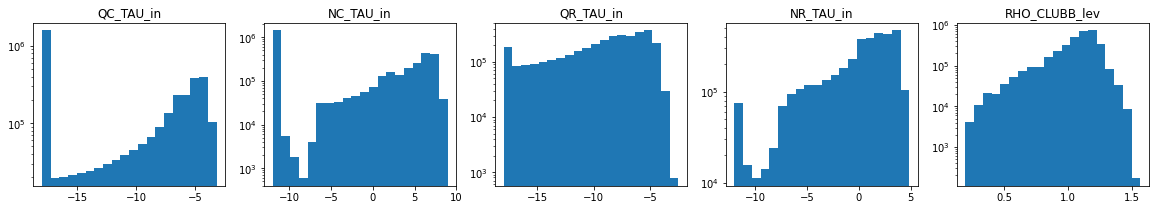

In [ ]:
# Histograms of original training input data by column

fig, axes = plt.subplots(1,5, figsize=(20, 3))
transformed_input_train = pd.DataFrame(input_scaler.inverse_transform(scaled_input_train), columns=input_cols)
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        ax.set_yscale("log")
        ax.hist(transformed_input_train[input_cols[a]], bins=20)
        ax.set_title(input_cols[a])
        

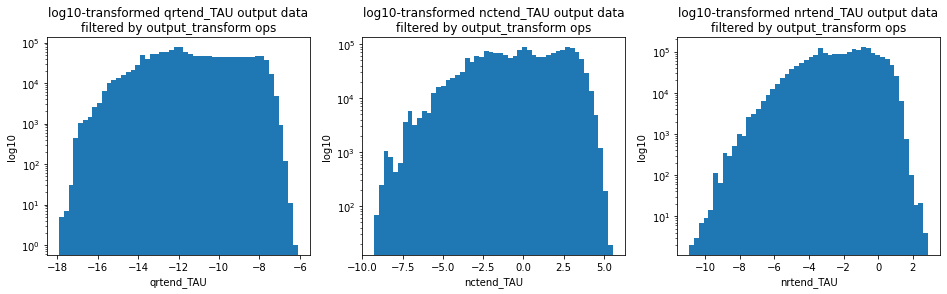

In [ ]:
# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
for output_col, ax in zip(output_cols, (ax1, ax2, ax3)):
    original_out_train_nc = np.zeros(scaled_out_train.shape[0])
    original_out_train_nc[labels_train[output_col] == 1] = -10 ** output_scalers[output_col][1].inverse_transform(
        scaled_out_train.loc[labels_train[output_col] == 1, [output_col]]).ravel()
    original_out_train_nc[labels_train[output_col] == -1] = -10 ** output_scalers[output_col][1].inverse_transform(
        scaled_out_train.loc[labels_train[output_col] == -1, [output_col]]).ravel()
    ax.hist(np.log10(-original_out_train_nc[original_out_train_nc < 0]), bins=50)
    ax.set_xlabel(output_col)
    ax.set_ylabel('log10')
    ax.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
    ax.set_yscale('log')


In [ ]:
# Inverse transform and scaling of scaled train data

original_out_train_nr = np.zeros(scaled_out_train.shape[0])
original_out_train_nr[labels_train["nrtend_TAU"] == 1] = 10 ** output_scalers["nrtend_TAU"][1].inverse_transform(
    scaled_out_train.loc[labels_train["nrtend_TAU"] == 1, ["nrtend_TAU"]]).ravel()
original_out_train_nr[labels_train["nrtend_TAU"] == -1] = -10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["nrtend_TAU"] == -1, ["nrtend_TAU"]]).ravel()


original_out_train_nc = np.zeros(scaled_out_train.shape[0])
original_out_train_nc[labels_train["nctend_TAU"] == 1] = -10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["nctend_TAU"] == 1, ["nctend_TAU"]]).ravel()

original_out_train_qr = np.zeros(scaled_out_train.shape[0])
original_out_train_qr[labels_train["qrtend_TAU"] == 1] = 10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["qrtend_TAU"] == 1, ["qrtend_TAU"]]).ravel()


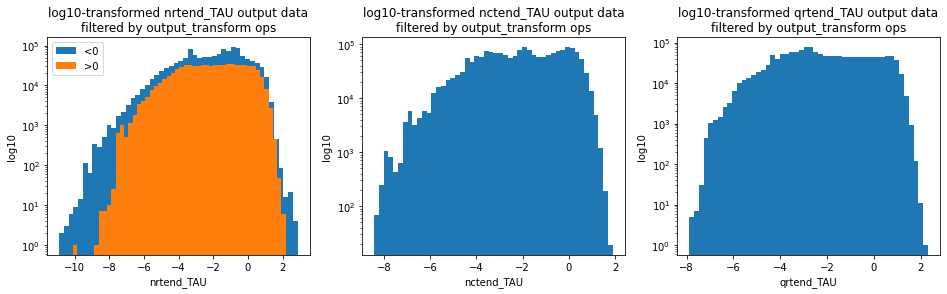

In [ ]:
# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

output_col = "nrtend_TAU"
ax1.hist(np.log10(-original_out_train_nr[original_out_train_nr < 0]), bins=50, label="<0")
ax1.hist(np.log10(original_out_train_nr[original_out_train_nr > 0]), bins=50, label=">0")
ax1.set_xlabel(output_col)
ax1.set_ylabel('log10')
ax1.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax1.set_yscale('log')
ax1.legend()

output_col = "nctend_TAU"
ax2.hist(np.log10(-original_out_train_nc[original_out_train_nc < 0]), bins=50)
ax2.set_xlabel(output_col)
ax2.set_ylabel('log10')
ax2.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax2.set_yscale('log')

output_col = "qrtend_TAU"
ax3.hist(np.log10(original_out_train_qr[original_out_train_qr > 0]), bins=50)
ax3.set_xlabel(output_col)
ax3.set_ylabel('log10')
ax3.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax3.set_yscale('log')

plt.show()


In [ ]:
# load and view a single file

fs = s3fs.S3FileSystem(anon=True)
filenames = fs.ls("s3://ncar-aiml-data-commons/microphysics")
fobj = fs.open(filenames[0])
single_file = pd.read_parquet(fobj).set_index('Index')
single_file.head()


,lat,lev,lon,P0,PS,depth,row,col,hyam,hybm,...,precip_frac,qctend_MG2,qctend_TAU,nctend_MG2,nctend_TAU,qrtend_MG2,qrtend_TAU,nrtend_MG2,nrtend_TAU,time
Index,,,,,,,,,,,,,,,,,,,,,
0,-88.115183,957.48548,28.75,100000.0,68814.664,29,2,23,0.006255,0.951231,...,0.5,-1.315998e-15,-2.864113e-25,-0.012213,-0.000461,1.315998e-15,0.0,0.000020,0.0,0.0
1,-88.115183,957.48548,30.00,100000.0,68741.100,29,2,24,0.006255,0.951231,...,0.5,-2.648823e-14,-5.759241e-25,-0.072859,-0.026884,2.648823e-14,0.0,0.000405,0.0,0.0
2,-88.115183,957.48548,31.25,100000.0,68667.195,29,2,25,0.006255,0.951231,...,1.0,-3.268663e-14,3.867864e-25,-0.108811,-0.059724,3.268663e-14,0.0,0.000499,0.0,0.0
3,-88.115183,957.48548,32.50,100000.0,68593.090,29,2,26,0.006255,0.951231,...,1.0,-8.188127e-14,-2.839463e-24,-0.187248,-0.176943,8.188127e-14,0.0,0.001251,0.0,0.0
4,-88.115183,957.48548,33.75,100000.0,68518.980,29,2,27,0.006255,0.951231,...,1.0,-1.991433e-13,2.097941e-24,-0.301633,-0.443875,1.991433e-13,0.0,0.003043,0.0,0.0


## Baseline Machine Learning Model
Description of baseline ML approach should include:
* Choice of ML software
* Type of ML model
* Hyperparameter choices and justification

A baseline model for solving this problem uses an in-series classifier to regressor neural network architecture implemented in Keras.  Initially, there are three classifier networks that feed into four regressor networks. Each classifier and regressor network has 4 hidden layers of 30 neurons each and relu activation. Those hidden layers then feed into a final output layer of size 2 or 3 for classification (1 and 0 or 1, 0, and -1) and of size 1 for regression. The classifier models are trained using the categorial crosstenropy loss function while the regression models are trained using the mean squared error loss function.

<center><img src='micro_images/mlmicrophysics_nn.png'><center>


In [ ]:
# define model hyper parameters

#classifier_metrics = ["acc", "pss", "hss"]
#regressor_metrics = ["mse", "mae", "r2", "hellinger"]

classifier_networks = {"hidden_layers" : 4,
                       "hidden_neurons" : 30,
                       "loss" : "categorical_crossentropy",
                       "output_activation" : "softmax",
                       "activation" : "relu",
                       "epochs" : 15,
                       "batch_size" : 1024,
                       "verbose" : 1,
                       "lr" : 0.0001,
                       "l2_weight" : 1.0e-5,
                       "classifier" : 1}

regressor_networks = {"hidden_layers" : 4,
                      "hidden_neurons" : 30,
                      "loss" : "mse",
                      "output_activation" : "linear",
                      "activation" : "relu",
                      "epochs" : 15,
                      "batch_size" : 1024,
                      "verbose" : 1,
                      "lr" : 0.0001,
                      "l2_weight" : 1.0e-5,
                      "classifier" : 0}

In [ ]:
# hyperparameter dictionaries
class_metrics = {"accuracy": accuracy_score,
                "heidke": heidke_skill_score,
                "peirce": peirce_skill_score}

reg_metrics = {"rmse": root_mean_squared_error,
              "mae": mean_absolute_error,
              "r2": r2_corr,
              "hellinger": hellinger_distance}

In [ ]:
#histories = {"classifiers": {}, "regressors": {}}
#print(histories)

#print(output_cols)

In [ ]:
# build and fit the model

histories = {"classifiers": {}, "regressors": {}}
classifiers = dict()
regressors = dict()
reg_index = []
for output_col in output_cols:
    for label in list(output_transforms[output_col].keys()):
        if label != 0:
            reg_index.append(output_col + f"_{label:d}")
test_prediction_values = np.zeros((scaled_out_test.shape[0], len(reg_index)))
test_prediction_labels = np.zeros(scaled_out_test.shape)
classifier_scores = pd.DataFrame(0, index=output_cols, columns=["accuracy", "heidke", "peirce"])
confusion_matrices = dict()
reg_cols = ["rmse", "mae", "r2", "hellinger"]
reg_scores = pd.DataFrame(0, index=reg_index, columns=reg_cols)
l = 0

for o, output_col in enumerate(output_cols):
    print("Train Classifer ", output_col)
    classifiers[output_col] = DenseNeuralNetwork(**classifier_networks)
    hist = classifiers[output_col].fit(scaled_input_train,
                                       labels_train[output_col],
                                       scaled_input_test,
                                       labels_test[output_col])
    histories["classifiers"][output_col] = hist
    classifiers[output_col].save_fortran_model(join(out_path,
                                                    "dnn_{0}_class_fortran.nc".format(output_col[0:2])))
    classifiers[output_col].model.save(join(out_path,"dnn_{0}_class.h5".format(output_col[0:2])))
    regressors[output_col] = dict()
    histories["regressors"][output_col] = dict()
    print("Evaluate Classifier", output_col)
    test_prediction_labels[:, o] = classifiers[output_col].predict(scaled_input_test)
    confusion_matrices[output_col] = confusion_matrix(labels_test[output_col],
                                                      test_prediction_labels  [:, o])
    for class_score in classifier_scores.columns:
        classifier_scores.loc[output_col, class_score] = class_metrics[class_score](labels_test[output_col],
                                                                                    test_prediction_labels[:, o])
    print(classifier_scores.loc[output_col])
    for label in list(output_transforms[output_col].keys()):
        if label != 0:
            print("Train Regressor ", output_col, label)
            regressors[output_col][label] = DenseNeuralNetwork(**regressor_networks)
            hist = regressors[output_col][label].fit(scaled_input_train.loc[labels_train[output_col] == label],
                                                     scaled_out_train.loc[labels_train[output_col] == label, output_col],
                                                     scaled_input_test.loc[labels_test[output_col] == label],
                                                     scaled_out_test.loc[labels_test[output_col] == label, output_col])
            histories["regressors"][output_col][label] = hist

            if label > 0:
                out_label = "pos"
            else:
                out_label = "neg"
            regressors[output_col][label].save_fortran_model(join(out_path,
                                                                  "dnn_{0}_{1}_fortran.nc".format(output_col[0:2],
                                                                                                  out_label)))
            regressors[output_col][label].model.save(join(out_path,
                                                          "dnn_{0}_{1}.h5".format(output_col[0:2], out_label)))
            print("Test Regressor", output_col, label)
            test_prediction_values[:, l] = output_scalers[output_col][label].inverse_transform(regressors[output_col][label].predict(scaled_input_test))
            reg_label = output_col + f"_{label:d}"
            for reg_col in reg_cols:
                reg_scores.loc[reg_label,
                               reg_col] = reg_metrics[reg_col](transformed_out_test.loc[labels_test[output_col] == label,
                                                                                        output_col],
                                                                test_prediction_values[labels_test[output_col] == label, l])
            print(reg_scores.loc[reg_label])
            l += 1
print("Saving data")
classifier_scores.to_csv(join(out_path, "dnn_classifier_scores.csv"), index_label="Output")
reg_scores.to_csv(join(out_path, "dnn_regressor_scores.csv"), index_label="Output")
test_pred_values_df = pd.DataFrame(test_prediction_values, columns=reg_index)
test_pred_labels_df = pd.DataFrame(test_prediction_labels, columns=output_cols)
test_pred_values_df.to_csv(join(out_path, "test_prediction_values.csv"), index_label="index")
test_pred_labels_df.to_csv(join(out_path, "test_prediction_labels.csv"), index_label="index")
labels_test.to_csv(join(out_path, "test_cam_labels.csv"), index_label="index")
transformed_out_test.to_csv(join(out_path, "test_cam_values.csv"), index_label="index")


Train Classifer  qrtend_TAU
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 30)                180       
_________________________________________________________________
dense_01 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_02 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_03 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_04 (Dense)             (None, 2)                 62        
Total params: 3,032
Trainable params: 3,032
Non-trainable params: 0
_______________________________

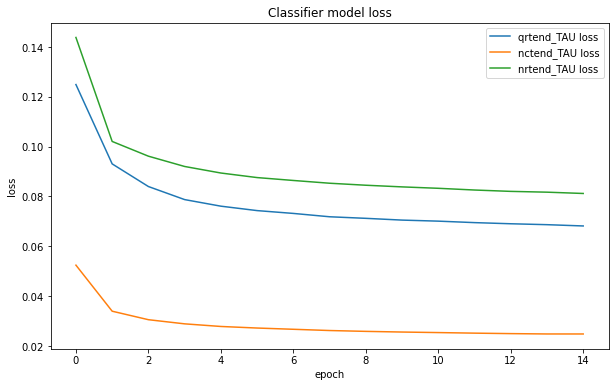

In [ ]:
# visualize classifier model performance

plt.figure(figsize=(10,6))
for k in histories['classifiers'].keys():
    plt.plot(histories['classifiers'][k]['loss'], label=f"{k} loss")
    # plt.plot(histories['classifiers'][k]['val_loss'], label=f"{k} val_loss")
plt.title('Classifier model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()


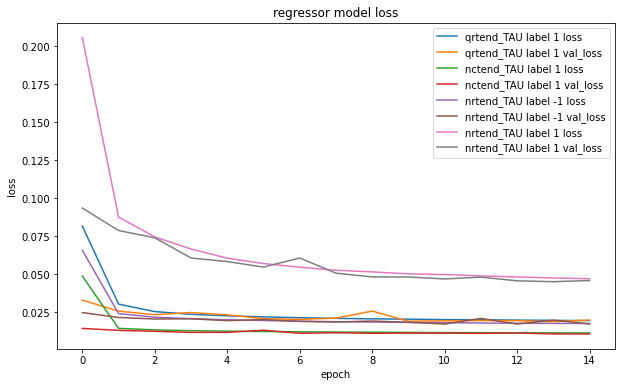

In [ ]:
# visualize regressor model performance

plt.figure(figsize=(10,6))
for k in histories['regressors'].keys():
    for l in histories['regressors'][k].keys():
        plt.plot(histories['regressors'][k][l]['loss'], label=f"{k} label {l} loss")
        plt.plot(histories['regressors'][k][l]['val_loss'], label=f"{k} label {l} val_loss")
plt.title('regressor model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()


## Metrics

Prediction metrics by output variable for classifier networks:

| Variable Name | accuracy | heidke | peirce |
| ------------- |:----------- |:----------- |:----------- |
| qrtend_TAU  |  0.98     | 0.97 | 0.99 | 
| nctend_TAU  |  0.99     | 0.99 | 0.97 |
| nrtend_TAU  |  0.98     | 0.97 | 0.99 |

Prediction metrics by output variable for regression networks:

| Variable Name | rmse | mae | r2 | hellinger |
| ------------- |:----------- |:----------- |:----------- |:----------- |
| qrtend_TAU_1  |  0.20     | 0.10 | 0.99 | 0.00056 |
| nctend_TAU_1  |  0.17     | 0.08 | 1.00 | 0.00099 |
| nrtend_TAU_-1  |  0.20     | 0.11 | 0.99 | 0.00056 |
| nrtend_TAU_1 | 0.25 | 0.16 | 0.98 | 0.00018 |



In [ ]:
# unscaled predicted output values

pred_tendencies = pd.DataFrame(0, index=scaled_out_test.index, columns=output_cols, dtype=float)

nr_pred_values = np.zeros(scaled_input_test.shape[0])
nr_pred_values[test_pred_labels_df["nrtend_TAU"] == 1] = (10 ** output_scalers["nrtend_TAU"][1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["nrtend_TAU"] == 1, ["nrtend_TAU_1"]])).flatten()
nr_pred_values[test_pred_labels_df["nrtend_TAU"] == -1] = (-10 ** output_scalers["nrtend_TAU"][-1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["nrtend_TAU"] == -1, ["nrtend_TAU_-1"]])).flatten()
pred_tendencies.loc[:, "nrtend_TAU"] = nr_pred_values

pred_tendencies.loc[test_pred_labels_df["nctend_TAU"] == 1, "nctend_TAU"] = (-10 ** output_scalers["nctend_TAU"][1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["nctend_TAU"] == 1, ["nctend_TAU_1"]])).ravel()

pred_tendencies.loc[test_pred_labels_df["qrtend_TAU"] == 1, "qrtend_TAU"] = (10 ** output_scalers["qrtend_TAU"][1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["qrtend_TAU"] == 1, ["qrtend_TAU_1"]])).ravel()


In [ ]:
# unscaled actual output values

unscaled_tendencies = pd.DataFrame(0, index=scaled_out_test.index, columns=output_cols, dtype=float)

nr_values = np.zeros(scaled_input_test.shape[0])
nr_values[labels_test["nrtend_TAU"] == 1] = (10 ** output_scalers["nrtend_TAU"][1].inverse_transform(
    scaled_out_test.loc[labels_test["nrtend_TAU"] == 1, ["nrtend_TAU"]])).flatten()
nr_values[labels_test["nrtend_TAU"] == -1] = (-10 ** output_scalers["nrtend_TAU"][-1].inverse_transform(
    scaled_out_test.loc[labels_test["nrtend_TAU"] == -1, ["nrtend_TAU"]])).flatten()
unscaled_tendencies.loc[:, "nrtend_TAU"] = nr_values

unscaled_tendencies.loc[labels_test["nctend_TAU"] == 1, "nctend_TAU"] = (-10 ** output_scalers["nctend_TAU"][1].inverse_transform(
    scaled_out_test.loc[labels_test["nctend_TAU"] == 1, ["nctend_TAU"]])).ravel()

unscaled_tendencies.loc[labels_test["qrtend_TAU"] == 1, "qrtend_TAU"] = (10 ** output_scalers["qrtend_TAU"][1].inverse_transform(
    scaled_out_test.loc[labels_test["qrtend_TAU"] == 1, ["qrtend_TAU"]])).ravel()

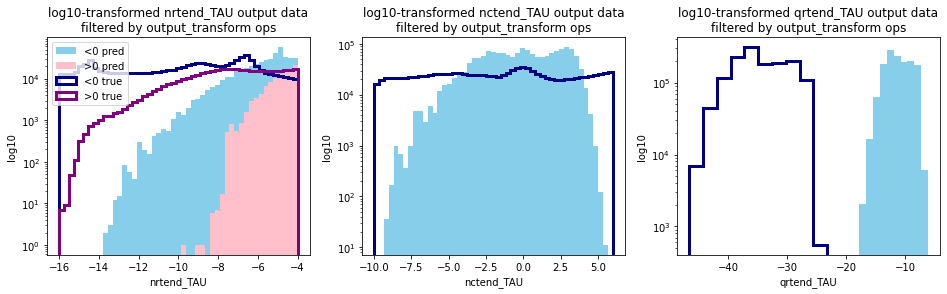

In [ ]:
# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
all_bins = [np.linspace(-16, -4, 50), np.linspace(-10, 6, 50), np.linspace(-200, 300, 50)]

output_col = "nrtend_TAU"
colp = unscaled_tendencies[output_col]
col = pred_tendencies[output_col]
ax1.hist(np.log10(-colp[colp < 0]), label="<0 pred", bins=all_bins[0], color='skyblue')
ax1.hist(np.log10(colp[colp > 0]), label=">0 pred", bins=all_bins[0], color='pink')
ax1.hist(np.log10(-col[col < 0]), label="<0 true", bins=all_bins[0], histtype="step", color="navy", lw=3)
ax1.hist(np.log10(col[col > 0]), label=">0 true", bins=all_bins[0], histtype="step", color="purple", lw=3)
ax1.set_xlabel(output_col)
ax1.set_ylabel('log10')
ax1.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax1.set_yscale('log')
ax1.legend()

output_col = "nctend_TAU"
colp = unscaled_tendencies[output_col]
col = pred_tendencies[output_col]
ax2.hist(np.log10(-colp[colp < 0]), label="pred", bins=all_bins[1], color='skyblue')
ax2.hist(np.log10(-col[col < 0]), label="true", bins=all_bins[1], histtype="step", color="navy", lw=3)
ax2.set_xlabel(output_col)
ax2.set_ylabel('log10')
ax2.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax2.set_yscale('log')

output_col = "qrtend_TAU"
colp = unscaled_tendencies[output_col]
col = pred_tendencies[output_col]
ax3.hist(np.log10(colp[colp > 0]), label="pred", color='skyblue')
ax3.hist(np.log10(col[col > 0]), label="true", histtype="step", color="navy", lw=3)
ax3.set_xlabel(output_col)
ax3.set_ylabel('log10')
ax3.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax3.set_yscale('log')

plt.show()


### References


Albrecht, B. A.  (1989).  Aerosols, cloud microphysics and fractional cloudiness.Sci-449ence,245, 1227–1230.

Bodas-Salcedo, A., Mulcahy, J. P., Andrews, T., Williams, K. D., Ringer, M. A.,455Field, P. R., & Elsaesser, G. S.(2019).Strong Dependence of Atmospheric456Feedbacks on Mixed-Phase Microphysics and Aerosol-Cloud Interactions in457HadGEM3.Journal of Advances in Modeling Earth Systems,11(6), 1735–1758.458doi:  10.1029/2019MS001688

Bogenschutz, P. A., Gettelman, A., Morrison, H., Larson, V. E., Craig, C., & Scha-460nen, D. P.(2013).Higher-order turbulence closure and its impact on Climate461Simulation in the Community Atmosphere Model.Journal of Climate,26(23),4629655–9676.  doi:  10.1175/JCLI-D-13-00075.1

Danabasoglu, G., Lamarque, J.-F., Bacmeister, J., Bailey, D. A., DuVivier, A. K.,471Edwards, J., . . .  Strand, W. G.(2020).The Community Earth System Model472Version 2 (CESM2).Journal of Advances in Modeling Earth Systems,12(2),473e2019MS001916.  doi:  10.1029/2019MS001916

Forbes, R. M., & Ahlgrimm, M.(2014, September).On the Representation of475High-Latitude Boundary Layer Mixed-Phase Cloud in the ECMWF Global Model.476Monthly Weather Review,142(9), 3425–3445.  doi:  10.1175/MWR-D-13-00325.1

Gettelman, A.(2015, November).Putting the clouds back in aerosol–cloud inter-478actions.Atmos. Chem. Phys.,15(21), 12397–12411.doi:  10.5194/acp-15-12397479-2015480

Gettelman, A., Bardeen, C. G., McCluskey, C. S., & Jarvinen, E.    (2020).    Simulat-481ing Observations of Southern Ocean Clouds and Implications for Climate.J. Adv.482Model. Earth Syst..  doi:  10.1029/2020JD032619483

Gettelman, A., Hannay, C., Bacmeister, J. T., Neale, R. B., Pendergrass, A. G.,484Danabasoglu, G., . . .  Mills, M. J.(2019).High Climate Sensitivity in the Com-485munity Earth System Model Version 2 (CESM2).Geophysical Research Letters,48646(14), 8329–8337.  doi:  10.1029/2019GL083978487

Gettelman, A., & Morrison, H.   (2015).   Advanced Two-Moment Bulk Microphysics488for Global Models. Part I: Off-Line Tests and Comparison with Other Schemes.J.489Climate,28(3), 1268–1287.  doi:  10.1175/JCLI-D-14-00102.1490

Gettelman, A., Morrison, H., Santos, S., Bogenschutz, P., & Caldwell, P. M.   (2015).491Advanced Two-Moment Bulk Microphysics for Global Models. Part II: Global492Model Solutions and Aerosol–Cloud Interactions.J. Climate,28(3), 1288–1307.493doi:  10.1175/JCLI-D-14-00103.1494

Gettelman, A., & Sherwood, S. C.  (2016, October).  Processes Responsible for Cloud495Feedback.Curr Clim Change Rep, 1–11.  doi:  10.1007/s40641-016-0052-8

Golaz, J.-C., Larson, V. E., & Cotton, W. R.(2002).A PDF-Based Model for497Boundary Layer Clouds. Part II: Model Results.J. Atmos. Sci.,59, 3552–3571.

Hoose, C., Kristj ́ansson, J. E., Chen, J.-P., & Hazra, A.  (2010, March).  A Classical-499Theory-Based Parameterization of Heterogeneous Ice Nucleation by Mineral Dust,500Soot, and Biological Particles in a Global Climate Model.J. Atmos. Sci.,67(8),5012483–2503.  doi:  10.1175/2010JAS3425.1

Iacono, M. J., Mlawer, E. J., Clough, S. A., & Morcrette, J.-J.  (2000).  Impact of an503improved longwave radiation model, RRTM, on the energy budget and thermody-504namic properties of the NCAR community climate model, CCM3.jgr,105(D11),50514,873–14,890.

Khairoutdinov, M. F., & Kogan, Y.  (2000).  A new cloud physics parameterization in507a large-eddy simulation model of marine stratocumulus.Monthly Weather Review,508128, 229–243.

Larson, V. E., Golaz, J.-C., & Cotton, W. R.(2002, December).Small-Scale and510Mesoscale Variability in Cloudy Boundary Layers:  Joint Probability Density Func-511tions.J. Atmos. Sci.,59(24), 3519–3539.   doi:  10.1175/1520-0469(2002)059〈3519:512SSAMVI〉2.0.CO;2

Liu, X., & Penner, J. E.  (2005).  Ice Nucleation Parameterization for Global Models.514Meteor. Z.,14(499-514).

Michibata, T., & Takemura, T.(2015, September).Evaluation of autoconversion520schemes in a single model framework with satellite observations.J. Geophys. Res.521Atmos.,120(18), 2015JD023818.  doi:  10.1002/2015JD023818

Neale, R. B., Richter, J. H., & Jochum, M.(2008).The Impact of Convection on523ENSO: From a Delayed Oscillator to a Series of Events.J. Climate,21, 5904-+.doi:  10.1175/2008JCLI2244.1

Pruppacher, H. R., & Klett, J. D.   (1997).Microphysics of Clouds and Precipitation526(Second ed.).  Kluwer Academic.

Seifert, A., & Beheng, K. D.  (2001).  A double-moment parameterization for simulat-531ing autoconversion, accretion and selfcollection.Atmos. Res.,59-60, 265–281.

Shi, X., Liu, X., & Zhang, K.  (2015, February).  Effects of pre-existing ice crystals on536cirrus clouds and comparison between different ice nucleation parameterizations537with the Community Atmosphere Model (CAM5).Atmospheric Chemistry and538Physics,15(3), 1503–1520.  doi:  10.5194/acp-15-1503-2015

Twomey, S.  (1977).  The influence of pollution on the shortwave albedo of clouds.J.553Atmos. Sci.,34(7), 1149–1152.

Wang, Y., Liu, X., Hoose, C., & Wang, B.(2014, October).Different contact555angle distributions for heterogeneous ice nucleation in the Community Atmo-556spheric Model version 5.Atmos. Chem. Phys.,14(19), 10411–10430.doi:55710.5194/acp-14-10411-2014

Zhang, G. J., & McFarlane, N. A.    (1995).    Sensitivity of climate simulations to the559parameterization of cumulus convection in the Canadian Climate Center general560circulation model.Atmos. Ocean,33, 407–446.

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [ ]:
# Monday's code goes here

In [ ]:
#import packages and set up 

import argparse
import random
import sys
import yaml
from os.path import join, exists
import os
import s3fs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error
import tensorflow as tf

from mlmicrophysics.metrics import heidke_skill_score, peirce_skill_score, hellinger_distance, root_mean_squared_error, r2_corr
from mlmicrophysics.models import DenseNeuralNetwork
from mlmicrophysics.data import subset_data_files_by_date, assemble_data_files


# set random seed
seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# define data parameters

data_path = "ncar-aiml-data-commons/microphysics"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    out_path = "/content/gdrive/My Drive/micro_models/base"
else:
    out_path = "./micro_models/base/"
if not exists(out_path):
    os.makedirs(out_path)
subsample = 0.1

input_cols = ["QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in", "RHO_CLUBB_lev"]
output_cols = ["qrtend_TAU", "nctend_TAU", "nrtend_TAU"]

subset_data = {"train_date_start" : 0,
               "train_date_end" : 11000,
               "test_date_start" : 11100,
               "test_date_end" : 17500}

In [ ]:
#--------------------------------------------------------------
## Try different input transforms
#--------------------------------------------------------------
#    * log10_transform: applies np.log10
#    * neg_log10_transform: applies np.log10 to the additive inverse of the inputs
#    * zero_transform: returns an array the same shape as the input but with all 0s
        
input_scaler = StandardScaler()
input_transforms = {"QC_TAU_in" : "log10_transform",
                    "NC_TAU_in" : "neg_log10_transform", #first change in the transform
                    "QR_TAU_in" : "log10_transform",
                    "NR_TAU_in" : "zero_transform"} #second change in the transform


#--------------------------------------------------------------
## Try different scalers
#--------------------------------------------------------------
# may choose from:

#input_scaler = MinMaxScaler () 
#input_scaler= MaxAbsScaler ()

#then, run the code below
#--------------------------------------------------------------

#define output transforms
output_transforms = {"qrtend_TAU" : {0: ["<=", 1e-18, "zero_transform", "None"],
                                   1: [">", 1e-18, "log10_transform", "StandardScaler"]},
                     "nctend_TAU" : {0: [">=", -1e-18, "zero_transform", "None"],
                                   1: ["<", -1e-18, "neg_log10_transform", "StandardScaler"]},
                     "nrtend_TAU" : {-1: ["<", 0, "neg_log10_transform", "StandardScaler"],
                                   0: ["==", 0, "zero_transform", "None"],
                                   1: [">", 0, "log10_transform", "StandardScaler"]}}


In [ ]:
# Load data from disk or cloud
# Separate input, output and meta data
# Split into training, validation, and test sets

print("Subsetting file paths by train, validation, and test")
train_files, val_files, test_files = subset_data_files_by_date(data_path, **subset_data)

print("\nLoading training data")
scaled_input_train, \
labels_train, \
transformed_out_train, \
scaled_out_train, \
output_scalers, \
meta_train = assemble_data_files(train_files, input_cols, output_cols, input_transforms,
                                 output_transforms, input_scaler, subsample=subsample)

print("\nLoading testing data")
scaled_input_test, \
labels_test, \
transformed_out_test, \
scaled_out_test, \
output_scalers_test, \
meta_test = assemble_data_files(test_files, input_cols, output_cols, input_transforms,
                                output_transforms, input_scaler, output_scalers=output_scalers,
                                train=False, subsample=subsample)


Subsetting file paths by train, validation, and test
File times:
 [    0   100   200   300   400   500   600   700   800   900  1000  1100
  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300
  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500
  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700
  4800  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900
  6000  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100
  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300
  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500
  9600  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700
 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900
 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100
 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300
 14400 14500 14600 14700 14800 14900 15000 15100 15200 153

In [ ]:
# save meta data, input scalers, and output scalers
    
meta_test.to_csv(join(out_path, "meta_test.csv"), index_label="index")

input_scaler_df = pd.DataFrame({"mean": input_scaler.mean_, "scale": input_scaler.scale_},
                               index=input_cols)
input_scaler_df.to_csv(join(out_path, "input_scale_values.csv"), index_label="input")

out_scales_list = []
for var in output_scalers.keys():
    for out_class in output_scalers[var].keys():
        if output_scalers[var][out_class] is not None:
            out_scales_list.append(pd.DataFrame({"mean": output_scalers[var][out_class].mean_,
                                                 "scale": output_scalers[var][out_class].scale_},
                                                index=[var + "_" + str(out_class)]))
out_scales_df = pd.concat(out_scales_list)
out_scales_df.to_csv(join(out_path, "output_scale_values.csv"),
                     index_label="output")
out_scales_df

,mean,scale
qrtend_TAU_1,-11.190049,2.089005
nctend_TAU_1,-0.172256,2.584713
nrtend_TAU_-1,-3.434289,2.271458
nrtend_TAU_1,-2.084925,1.801713


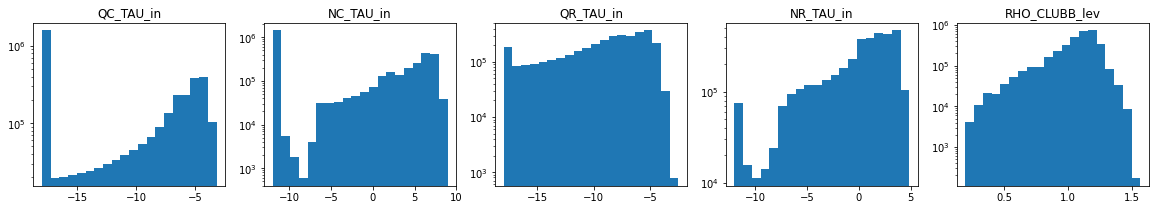

In [ ]:
# Histograms of original training input data by column

fig, axes = plt.subplots(1,5, figsize=(20, 3))
transformed_input_train = pd.DataFrame(input_scaler.inverse_transform(scaled_input_train), columns=input_cols)
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        ax.set_yscale("log")
        ax.hist(transformed_input_train[input_cols[a]], bins=20)
        ax.set_title(input_cols[a])
        

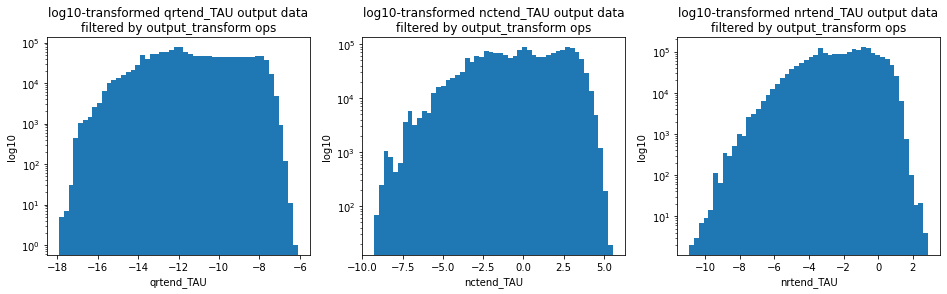

In [ ]:
#---------------------------------------------------------
# Non-transformed output visualizations
#---------------------------------------------------------
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
for output_col, ax in zip(output_cols, (ax1, ax2, ax3)):
    original_out_train_nc = np.zeros(scaled_out_train.shape[0])
    original_out_train_nc[labels_train[output_col] == 1] = -10 ** output_scalers[output_col][1].inverse_transform(
        scaled_out_train.loc[labels_train[output_col] == 1, [output_col]]).ravel()
    original_out_train_nc[labels_train[output_col] == -1] = -10 ** output_scalers[output_col][1].inverse_transform(
        scaled_out_train.loc[labels_train[output_col] == -1, [output_col]]).ravel()
    ax.hist(np.log10(-original_out_train_nc[original_out_train_nc < 0]), bins=50)
    ax.set_xlabel(output_col)
    ax.set_ylabel('log10')
    ax.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
    ax.set_yscale('log')


In [ ]:
#--------------------------------------------------------------
# Inverse transform and scaling of scaled train data
#--------------------------------------------------------------

original_out_train_nr = np.zeros(scaled_out_train.shape[0])
original_out_train_nr[labels_train["nrtend_TAU"] == 1] = 10 ** output_scalers["nrtend_TAU"][1].inverse_transform(
    scaled_out_train.loc[labels_train["nrtend_TAU"] == 1, ["nrtend_TAU"]]).ravel()
original_out_train_nr[labels_train["nrtend_TAU"] == -1] = -10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["nrtend_TAU"] == -1, ["nrtend_TAU"]]).ravel()


original_out_train_nc = np.zeros(scaled_out_train.shape[0])
original_out_train_nc[labels_train["nctend_TAU"] == 1] = -10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["nctend_TAU"] == 1, ["nctend_TAU"]]).ravel()

original_out_train_qr = np.zeros(scaled_out_train.shape[0])
original_out_train_qr[labels_train["qrtend_TAU"] == 1] = 10 ** output_scalers[output_col][1].inverse_transform(
    scaled_out_train.loc[labels_train["qrtend_TAU"] == 1, ["qrtend_TAU"]]).ravel()


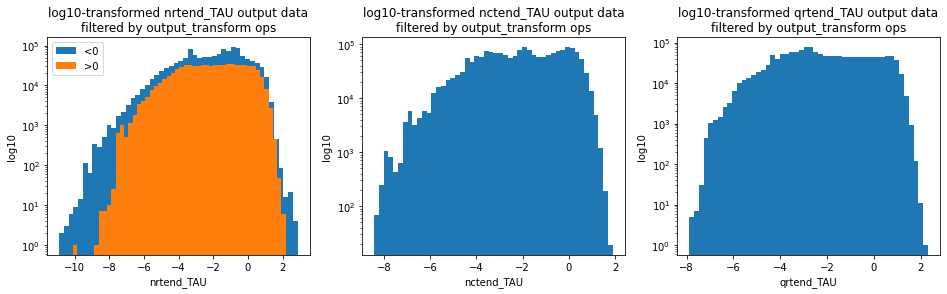

In [ ]:
#--------------------------------------------------------------
# output visualizations (of transformed data)
#--------------------------------------------------------------

# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

output_col = "nrtend_TAU"
ax1.hist(np.log10(-original_out_train_nr[original_out_train_nr < 0]), bins=50, label="<0")
ax1.hist(np.log10(original_out_train_nr[original_out_train_nr > 0]), bins=50, label=">0")
ax1.set_xlabel(output_col)
ax1.set_ylabel('log10')
ax1.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax1.set_yscale('log')
ax1.legend()

output_col = "nctend_TAU"
ax2.hist(np.log10(-original_out_train_nc[original_out_train_nc < 0]), bins=50)
ax2.set_xlabel(output_col)
ax2.set_ylabel('log10')
ax2.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax2.set_yscale('log')

output_col = "qrtend_TAU"
ax3.hist(np.log10(original_out_train_qr[original_out_train_qr > 0]), bins=50)
ax3.set_xlabel(output_col)
ax3.set_ylabel('log10')
ax3.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax3.set_yscale('log')

plt.show()


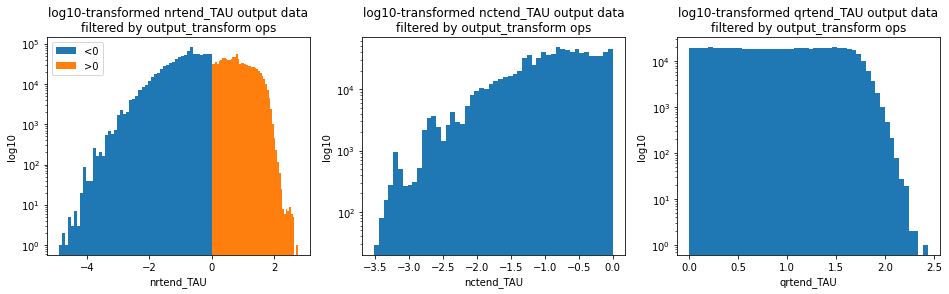

In [ ]:
#--------------------------------------------------------------
# output visualizations of non-transformed scaled data
#--------------------------------------------------------------
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

output_col = "nrtend_TAU"
ax1.hist(scaled_out_train[output_col][scaled_out_train[output_col] < 0], bins=50, label="<0")
ax1.hist(scaled_out_train[output_col][scaled_out_train[output_col] > 0], bins=50, label=">0")
ax1.set_xlabel(output_col)
ax1.set_ylabel('log10')
ax1.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax1.set_yscale('log')
ax1.legend()

output_col = "nctend_TAU"
ax2.hist(scaled_out_train[output_col][scaled_out_train[output_col] < 0], bins=50, label="<0")
#ax2.hist(scaled_out_train[output_col][scaled_out_train[output_col] > 0], bins=50, label=">0")ax2.set_xlabel(output_col)
ax2.set_xlabel(output_col)
ax2.set_ylabel('log10')
ax2.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax2.set_yscale('log')

output_col = "qrtend_TAU"
#ax3.hist(scaled_out_train[output_col][scaled_out_train[output_col] < 0], bins=50, label="<0")
ax3.hist(scaled_out_train[output_col][scaled_out_train[output_col] > 0], bins=50, label=">0")
ax3.set_xlabel(output_col)
ax3.set_ylabel('log10')
ax3.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax3.set_yscale('log')

plt.show()

In [ ]:
#--------------------------------------------------------------
# train a linear model (scaled output only)
#--------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#using scaled data only
X=scaled_input_train
y=scaled_out_train 

#print(Y)
#X = scaled_input_train[[‘QC_TAU_in’, ‘NC_TAU_in’, ‘QR_TAU_in’, ‘NR_TAU_in’, ‘RHO_CLUBB_lev’]]
#Y = scaled_out_train[‘qrtend_TAU' 'nctend_TAU'  'nrtend_TAU’]
linear_model = LinearRegression().fit(X, y)

#make prediction using training data
train_predict_y=linear_model.predict(X)
                                      
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y, train_predict_y))   

Mean squared error: 0.46


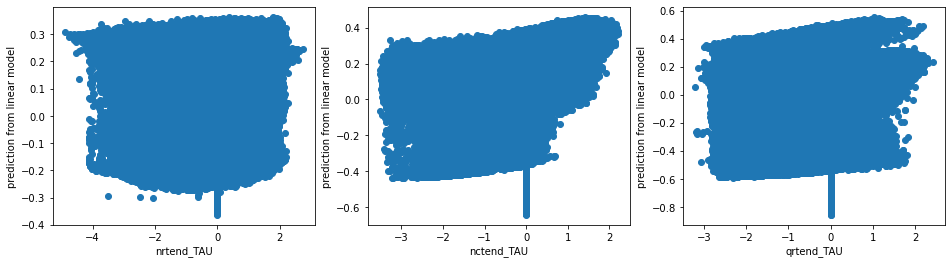

In [ ]:
# output visualizations true y-value vs. prediction

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

output_col = "nrtend_TAU"
ax1.scatter(scaled_out_train[output_col],train_predict_y[:,0])
ax1.set_xlabel(output_col)
ax1.set_ylabel('prediction from linear model')
#ax1.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
#ax1.set_yscale('log')
#ax1.legend()
#ax1.set_yscale('log')
#ax1.set_xscale('log')

output_col = "nctend_TAU"
ax2.scatter(scaled_out_train[output_col],train_predict_y[:,1])
ax2.set_ylabel('prediction from linear model')
ax2.set_xlabel(output_col)
#ax2.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
#ax2.set_yscale('log')
#ax2.set_xscale('log')

output_col = "qrtend_TAU"
ax3.scatter(scaled_out_train[output_col],train_predict_y[:,2])
ax3.set_xlabel(output_col)
ax3.set_ylabel('prediction from linear model')
#ax3.set_yscale('log')
#ax3.set_xscale('log')

plt.show()

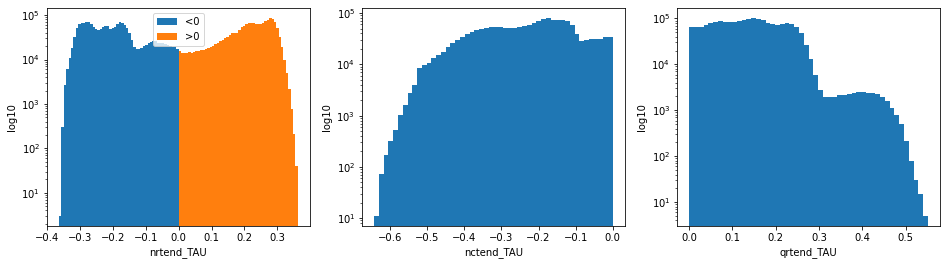

In [ ]:
#--------------------------------------------------------------
# output visualizations of non-transformed scaled data
#--------------------------------------------------------------

# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

output_col = "nrtend_TAU"
ax1.hist(train_predict_y[:,0][train_predict_y[:,0] < 0], bins=50, label="<0")
ax1.hist(train_predict_y[:,0][train_predict_y[:,0] > 0], bins=50, label=">0")
ax1.set_xlabel(output_col)
ax1.set_ylabel('log10')
#ax1.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax1.set_yscale('log')
ax1.legend()

output_col = "nctend_TAU"
ax2.hist(train_predict_y[:,1][train_predict_y[:,1] < 0], bins=50, label="<0")
#ax2.hist(train_predict_y[output_col][train_predict_y[output_col] > 0], bins=50, label=">0")ax2.set_xlabel(output_col)
ax2.set_ylabel('log10')
ax2.set_xlabel(output_col)
#ax2.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax2.set_yscale('log')

output_col = "qrtend_TAU"
#ax3.hist(train_predict_y[output_col][train_predict_y[output_col] < 0], bins=50, label="<0")
ax3.hist(train_predict_y[:,2][train_predict_y[:,2] > 0], bins=50, label=">0")
ax3.set_xlabel(output_col)
ax3.set_ylabel('log10')
#ax3.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax3.set_yscale('log')

plt.show()

In [ ]:
# Dimension reduction by Principle component PCA decomposition
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca_train=pca.fit_transform(scaled_input_train)

pca_scaled_model=LinearRegression().fit(X_pca_train,y)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.4955786  0.32041155 0.18400985]
[2301.54584989 1850.62081067 1402.43870311]


In [ ]:
 #make prediction using training data
train_predict_y_pca=pca_scaled_model.predict(X_pca_train)
                                      
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y, train_predict_y_pca))    

Mean squared error: 0.46


In [ ]:
#Train a decision tree
#Work in progress
from sklearn import tree

#using scaled data only
X=scaled_input_train
y=scaled_out_train 

#need to provide more parameters

# Create Decision Tree classifer object
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

#Predict the response for test dataset
y_decision_tree = clf.predict(X)

#--------------------------------------------------------------

### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [ ]:
# Tuesday's code goes here

In [ ]:
# hyperparameter dictionaries
class_metrics = {"accuracy": accuracy_score,
                "heidke": heidke_skill_score,
                "peirce": peirce_skill_score}

reg_metrics = {"rmse": root_mean_squared_error,
              "mae": mean_absolute_error,
              "r2": r2_corr,
              "hellinger": hellinger_distance}

In [ ]:
# define model hyper parameters

#default values
#classifier_networks = {"hidden_layers" : 4,
#                       "hidden_neurons" : 30,
#                       "loss" : "categorical_crossentropy",
#                       "output_activation" : "softmax",
#                       "activation" : "relu",
#                       "epochs" : 15,
#                       "batch_size" : 1024,
#                       "verbose" : 1,
#                       "lr" : 0.0001,
#                       "l2_weight" : 1.0e-5,
#                       "classifier" : 1}

#regressor_networks = {"hidden_layers" : 4,
#                      "hidden_neurons" : 30,
#                      "loss" : "mse",
#                      "output_activation" : "linear",
#                      "activation" : "relu",
#                      "epochs" : 15,
#                      "batch_size" : 1024,
#                      "verbose" : 1,
#                      "lr" : 0.0001,
#                      "l2_weight" : 1.0e-5,
#                      "classifier" : 0}


#change default values (use 8 layers of the deep NN)
classifier_networks = {"hidden_layers" : 8,
                       "hidden_neurons" : 30,
                       "loss" : "categorical_crossentropy",
                       "output_activation" : "softmax",
                       "activation" : "relu",
                       "epochs" : 15,
                       "batch_size" : 1024,
                       "verbose" : 1,
                       "lr" : 0.0001,
                       "l2_weight" : 1.0e-5,
                       "classifier" : 1}

regressor_networks = {"hidden_layers" : 8,
                      "hidden_neurons" : 30,
                      "loss" : "mse",
                      "output_activation" : "linear",
                      "activation" : "relu",
                      "epochs" : 15,
                      "batch_size" : 1024,
                      "verbose" : 1,
                      "lr" : 0.0001,
                      "l2_weight" : 1.0e-5,
                      "classifier" : 0}

In [ ]:
# build and fit the model 
#Dense Neural Network
#A Dense Neural Network Model that can support arbitrary numbers of hidden layers.

histories = {"classifiers": {}, "regressors": {}}
classifiers = dict()
regressors = dict()
reg_index = []
for output_col in output_cols:
    for label in list(output_transforms[output_col].keys()):
        if label != 0:
            reg_index.append(output_col + f"_{label:d}")
test_prediction_values = np.zeros((scaled_out_test.shape[0], len(reg_index)))
test_prediction_labels = np.zeros(scaled_out_test.shape)
classifier_scores = pd.DataFrame(0, index=output_cols, columns=["accuracy", "heidke", "peirce"])
confusion_matrices = dict()
reg_cols = ["rmse", "mae", "r2", "hellinger"]
reg_scores = pd.DataFrame(0, index=reg_index, columns=reg_cols)
l = 0

for o, output_col in enumerate(output_cols):
    print("Train Classifer ", output_col)
    classifiers[output_col] = DenseNeuralNetwork(**classifier_networks)
    hist = classifiers[output_col].fit(scaled_input_train,
                                       labels_train[output_col],
                                       scaled_input_test,
                                       labels_test[output_col])
    histories["classifiers"][output_col] = hist
    classifiers[output_col].save_fortran_model(join(out_path,
                                                    "dnn_{0}_class_fortran.nc".format(output_col[0:2])))
    classifiers[output_col].model.save(join(out_path,"dnn_{0}_class.h5".format(output_col[0:2])))
    regressors[output_col] = dict()
    histories["regressors"][output_col] = dict()
    print("Evaluate Classifier", output_col)
    test_prediction_labels[:, o] = classifiers[output_col].predict(scaled_input_test)
    confusion_matrices[output_col] = confusion_matrix(labels_test[output_col],
                                                      test_prediction_labels  [:, o])
    for class_score in classifier_scores.columns:
        classifier_scores.loc[output_col, class_score] = class_metrics[class_score](labels_test[output_col],
                                                                                    test_prediction_labels[:, o])
    print(classifier_scores.loc[output_col])
    for label in list(output_transforms[output_col].keys()):
        if label != 0:
            print("Train Regressor ", output_col, label)
            regressors[output_col][label] = DenseNeuralNetwork(**regressor_networks)
            hist = regressors[output_col][label].fit(scaled_input_train.loc[labels_train[output_col] == label],
                                                     scaled_out_train.loc[labels_train[output_col] == label, output_col],
                                                     scaled_input_test.loc[labels_test[output_col] == label],
                                                     scaled_out_test.loc[labels_test[output_col] == label, output_col])
            histories["regressors"][output_col][label] = hist

            if label > 0:
                out_label = "pos"
            else:
                out_label = "neg"
            regressors[output_col][label].save_fortran_model(join(out_path,
                                                                  "dnn_{0}_{1}_fortran.nc".format(output_col[0:2],
                                                                                                  out_label)))
            regressors[output_col][label].model.save(join(out_path,
                                                          "dnn_{0}_{1}.h5".format(output_col[0:2], out_label)))
            print("Test Regressor", output_col, label)
            test_prediction_values[:, l] = output_scalers[output_col][label].inverse_transform(regressors[output_col][label].predict(scaled_input_test))
            reg_label = output_col + f"_{label:d}"
            for reg_col in reg_cols:
                reg_scores.loc[reg_label,
                               reg_col] = reg_metrics[reg_col](transformed_out_test.loc[labels_test[output_col] == label,
                                                                                        output_col],
                                                                test_prediction_values[labels_test[output_col] == label, l])
            print(reg_scores.loc[reg_label])
            l += 1
print("Saving data")
classifier_scores.to_csv(join(out_path, "dnn_classifier_scores.csv"), index_label="Output")
reg_scores.to_csv(join(out_path, "dnn_regressor_scores.csv"), index_label="Output")
test_pred_values_df = pd.DataFrame(test_prediction_values, columns=reg_index)
test_pred_labels_df = pd.DataFrame(test_prediction_labels, columns=output_cols)
test_pred_values_df.to_csv(join(out_path, "test_prediction_values.csv"), index_label="index")
test_pred_labels_df.to_csv(join(out_path, "test_prediction_labels.csv"), index_label="index")
labels_test.to_csv(join(out_path, "test_cam_labels.csv"), index_label="index")
transformed_out_test.to_csv(join(out_path, "test_cam_values.csv"), index_label="index")

Train Classifer  qrtend_TAU
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 30)                180       
_________________________________________________________________
dense_01 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_02 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_03 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_04 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_05 (Dense)             (

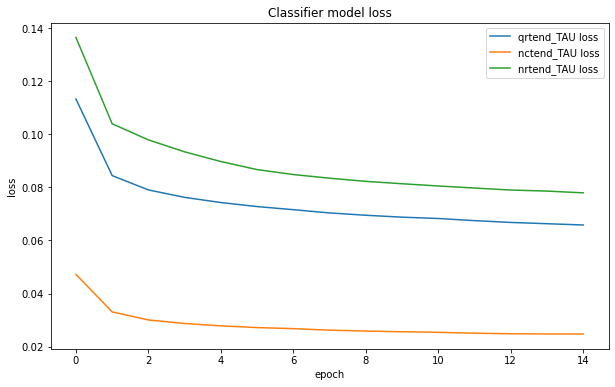

In [ ]:
# visualize classifier model performance

plt.figure(figsize=(10,6))
for k in histories['classifiers'].keys():
    plt.plot(histories['classifiers'][k]['loss'], label=f"{k} loss")
    # plt.plot(histories['classifiers'][k]['val_loss'], label=f"{k} val_loss")
plt.title('Classifier model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

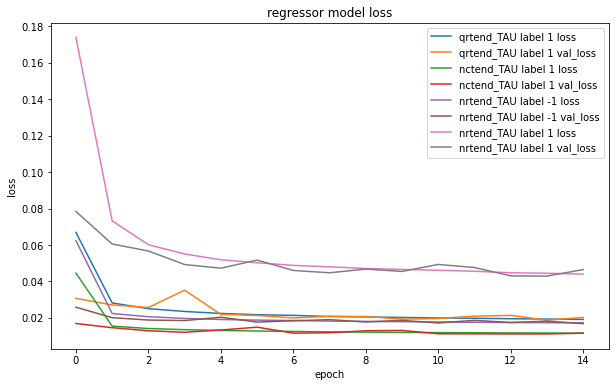

In [ ]:
# visualize regressor model performance

plt.figure(figsize=(10,6))
for k in histories['regressors'].keys():
    for l in histories['regressors'][k].keys():
        plt.plot(histories['regressors'][k][l]['loss'], label=f"{k} label {l} loss")
        plt.plot(histories['regressors'][k][l]['val_loss'], label=f"{k} label {l} val_loss")
plt.title('regressor model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# calculate Metrics

# unscaled predicted output values

pred_tendencies = pd.DataFrame(0, index=scaled_out_test.index, columns=output_cols, dtype=float)

nr_pred_values = np.zeros(scaled_input_test.shape[0])
nr_pred_values[test_pred_labels_df["nrtend_TAU"] == 1] = (10 ** output_scalers["nrtend_TAU"][1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["nrtend_TAU"] == 1, ["nrtend_TAU_1"]])).flatten()
nr_pred_values[test_pred_labels_df["nrtend_TAU"] == -1] = (-10 ** output_scalers["nrtend_TAU"][-1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["nrtend_TAU"] == -1, ["nrtend_TAU_-1"]])).flatten()
pred_tendencies.loc[:, "nrtend_TAU"] = nr_pred_values

pred_tendencies.loc[test_pred_labels_df["nctend_TAU"] == 1, "nctend_TAU"] = (-10 ** output_scalers["nctend_TAU"][1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["nctend_TAU"] == 1, ["nctend_TAU_1"]])).ravel()

pred_tendencies.loc[test_pred_labels_df["qrtend_TAU"] == 1, "qrtend_TAU"] = (10 ** output_scalers["qrtend_TAU"][1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["qrtend_TAU"] == 1, ["qrtend_TAU_1"]])).ravel()

# unscaled actual output values

unscaled_tendencies = pd.DataFrame(0, index=scaled_out_test.index, columns=output_cols, dtype=float)

nr_values = np.zeros(scaled_input_test.shape[0])
nr_values[labels_test["nrtend_TAU"] == 1] = (10 ** output_scalers["nrtend_TAU"][1].inverse_transform(
    scaled_out_test.loc[labels_test["nrtend_TAU"] == 1, ["nrtend_TAU"]])).flatten()
nr_values[labels_test["nrtend_TAU"] == -1] = (-10 ** output_scalers["nrtend_TAU"][-1].inverse_transform(
    scaled_out_test.loc[labels_test["nrtend_TAU"] == -1, ["nrtend_TAU"]])).flatten()
unscaled_tendencies.loc[:, "nrtend_TAU"] = nr_values

unscaled_tendencies.loc[labels_test["nctend_TAU"] == 1, "nctend_TAU"] = (-10 ** output_scalers["nctend_TAU"][1].inverse_transform(
    scaled_out_test.loc[labels_test["nctend_TAU"] == 1, ["nctend_TAU"]])).ravel()

unscaled_tendencies.loc[labels_test["qrtend_TAU"] == 1, "qrtend_TAU"] = (10 ** output_scalers["qrtend_TAU"][1].inverse_transform(
    scaled_out_test.loc[labels_test["qrtend_TAU"] == 1, ["qrtend_TAU"]])).ravel()

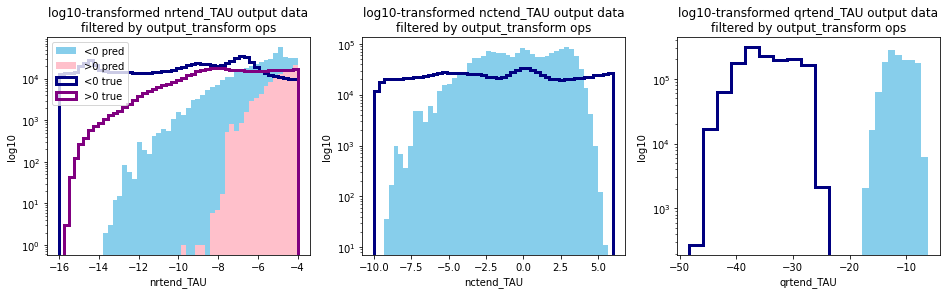

In [ ]:
# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
all_bins = [np.linspace(-16, -4, 50), np.linspace(-10, 6, 50), np.linspace(-200, 300, 50)]

output_col = "nrtend_TAU"
colp = unscaled_tendencies[output_col]
col = pred_tendencies[output_col]
ax1.hist(np.log10(-colp[colp < 0]), label="<0 pred", bins=all_bins[0], color='skyblue')
ax1.hist(np.log10(colp[colp > 0]), label=">0 pred", bins=all_bins[0], color='pink')
ax1.hist(np.log10(-col[col < 0]), label="<0 true", bins=all_bins[0], histtype="step", color="navy", lw=3)
ax1.hist(np.log10(col[col > 0]), label=">0 true", bins=all_bins[0], histtype="step", color="purple", lw=3)
ax1.set_xlabel(output_col)
ax1.set_ylabel('log10')
ax1.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax1.set_yscale('log')
ax1.legend()

output_col = "nctend_TAU"
colp = unscaled_tendencies[output_col]
col = pred_tendencies[output_col]
ax2.hist(np.log10(-colp[colp < 0]), label="pred", bins=all_bins[1], color='skyblue')
ax2.hist(np.log10(-col[col < 0]), label="true", bins=all_bins[1], histtype="step", color="navy", lw=3)
ax2.set_xlabel(output_col)
ax2.set_ylabel('log10')
ax2.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax2.set_yscale('log')

output_col = "qrtend_TAU"
colp = unscaled_tendencies[output_col]
col = pred_tendencies[output_col]
ax3.hist(np.log10(colp[colp > 0]), label="pred", color='skyblue')
ax3.hist(np.log10(col[col > 0]), label="true", histtype="step", color="navy", lw=3)
ax3.set_xlabel(output_col)
ax3.set_ylabel('log10')
ax3.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax3.set_yscale('log')

plt.show()

In [ ]:
#change default values
classifier_networks = {"hidden_layers" : 4,
                       "hidden_neurons" : 30,
                       "loss" : "categorical_crossentropy",
                       "output_activation" : "softmax",
                       "activation" : "relu",
                       "epochs" : 15,
                       "batch_size" : 1024,
                       "verbose" : 1,
                       "lr" : 0.0001,
                       "l2_weight" : 1.0e-5,
                       "classifier" : 1}

regressor_networks = {"hidden_layers" : 4,
                      "hidden_neurons" : 30,
                      "loss" : "mse",
                      "output_activation" : "linear",
                      "activation" : "relu",
                      "epochs" : 15,
                      "batch_size" : 1024,
                      "verbose" : 1,
                      "lr" : 0.0001,
                      "l2_weight" : 1.0e-5,
                      "classifier" : 0}

In [ ]:
# build and fit the model 
#DenseGAN
#A conditional generative adversarial network consisting of dense neural networks for the generator
#and discriminator.
    
histories = {"classifiers": {}, "regressors": {}}
classifiers = dict()
regressors = dict()
reg_index = []
for output_col in output_cols:
    for label in list(output_transforms[output_col].keys()):
        if label != 0:
            reg_index.append(output_col + f"_{label:d}")
test_prediction_values = np.zeros((scaled_out_test.shape[0], len(reg_index)))
test_prediction_labels = np.zeros(scaled_out_test.shape)
classifier_scores = pd.DataFrame(0, index=output_cols, columns=["accuracy", "heidke", "peirce"])
confusion_matrices = dict()
reg_cols = ["rmse", "mae", "r2", "hellinger"]
reg_scores = pd.DataFrame(0, index=reg_index, columns=reg_cols)
l = 0

for o, output_col in enumerate(output_cols):
    print("Train Classifer ", output_col)
    classifiers[output_col] = DenseNeuralNetwork(**classifier_networks)
    hist = classifiers[output_col].fit(scaled_input_train,
                                       labels_train[output_col],
                                       scaled_input_test,
                                       labels_test[output_col])
    histories["classifiers"][output_col] = hist
    classifiers[output_col].save_fortran_model(join(out_path,
                                                    "dnn_{0}_class_fortran.nc".format(output_col[0:2])))
    classifiers[output_col].model.save(join(out_path,"dnn_{0}_class.h5".format(output_col[0:2])))
    regressors[output_col] = dict()
    histories["regressors"][output_col] = dict()
    print("Evaluate Classifier", output_col)
    test_prediction_labels[:, o] = classifiers[output_col].predict(scaled_input_test)
    confusion_matrices[output_col] = confusion_matrix(labels_test[output_col],
                                                      test_prediction_labels  [:, o])
    for class_score in classifier_scores.columns:
        classifier_scores.loc[output_col, class_score] = class_metrics[class_score](labels_test[output_col],
                                                                                    test_prediction_labels[:, o])
    print(classifier_scores.loc[output_col])
    for label in list(output_transforms[output_col].keys()):
        if label != 0:
            print("Train Regressor ", output_col, label)
            regressors[output_col][label] = DenseNeuralNetwork(**regressor_networks)
            hist = regressors[output_col][label].fit(scaled_input_train.loc[labels_train[output_col] == label],
                                                     scaled_out_train.loc[labels_train[output_col] == label, output_col],
                                                     scaled_input_test.loc[labels_test[output_col] == label],
                                                     scaled_out_test.loc[labels_test[output_col] == label, output_col])
            histories["regressors"][output_col][label] = hist

            if label > 0:
                out_label = "pos"
            else:
                out_label = "neg"
            regressors[output_col][label].save_fortran_model(join(out_path,
                                                                  "dnn_{0}_{1}_fortran.nc".format(output_col[0:2],
                                                                                                  out_label)))
            regressors[output_col][label].model.save(join(out_path,
                                                          "dnn_{0}_{1}.h5".format(output_col[0:2], out_label)))
            print("Test Regressor", output_col, label)
            test_prediction_values[:, l] = output_scalers[output_col][label].inverse_transform(regressors[output_col][label].predict(scaled_input_test))
            reg_label = output_col + f"_{label:d}"
            for reg_col in reg_cols:
                reg_scores.loc[reg_label,
                               reg_col] = reg_metrics[reg_col](transformed_out_test.loc[labels_test[output_col] == label,
                                                                                        output_col],
                                                                test_prediction_values[labels_test[output_col] == label, l])
            print(reg_scores.loc[reg_label])
            l += 1
print("Saving data")
classifier_scores.to_csv(join(out_path, "dnn_classifier_scores.csv"), index_label="Output")
reg_scores.to_csv(join(out_path, "dnn_regressor_scores.csv"), index_label="Output")
test_pred_values_df = pd.DataFrame(test_prediction_values, columns=reg_index)
test_pred_labels_df = pd.DataFrame(test_prediction_labels, columns=output_cols)
test_pred_values_df.to_csv(join(out_path, "test_prediction_values.csv"), index_label="index")
test_pred_labels_df.to_csv(join(out_path, "test_prediction_labels.csv"), index_label="index")
labels_test.to_csv(join(out_path, "test_cam_labels.csv"), index_label="index")
transformed_out_test.to_csv(join(out_path, "test_cam_values.csv"), index_label="index")

Train Classifer  qrtend_TAU
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 30)                180       
_________________________________________________________________
dense_01 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_02 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_03 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_04 (Dense)             (None, 2)                 62        
Total params: 3,032
Trainable params: 3,032
Non-trainable params: 0
____________________________

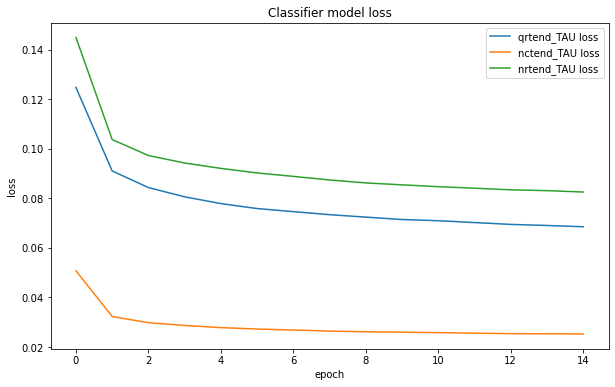

In [ ]:
# visualize classifier model performance

plt.figure(figsize=(10,6))
for k in histories['classifiers'].keys():
    plt.plot(histories['classifiers'][k]['loss'], label=f"{k} loss")
    # plt.plot(histories['classifiers'][k]['val_loss'], label=f"{k} val_loss")
plt.title('Classifier model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()


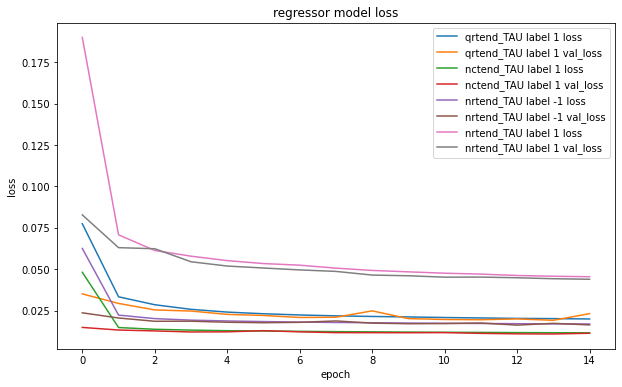

In [ ]:
# visualize regressor model performance

plt.figure(figsize=(10,6))
for k in histories['regressors'].keys():
    for l in histories['regressors'][k].keys():
        plt.plot(histories['regressors'][k][l]['loss'], label=f"{k} label {l} loss")
        plt.plot(histories['regressors'][k][l]['val_loss'], label=f"{k} label {l} val_loss")
plt.title('regressor model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Calculate Metrics 
# unscaled predicted output values

pred_tendencies = pd.DataFrame(0, index=scaled_out_test.index, columns=output_cols, dtype=float)

nr_pred_values = np.zeros(scaled_input_test.shape[0])
nr_pred_values[test_pred_labels_df["nrtend_TAU"] == 1] = (10 ** output_scalers["nrtend_TAU"][1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["nrtend_TAU"] == 1, ["nrtend_TAU_1"]])).flatten()
nr_pred_values[test_pred_labels_df["nrtend_TAU"] == -1] = (-10 ** output_scalers["nrtend_TAU"][-1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["nrtend_TAU"] == -1, ["nrtend_TAU_-1"]])).flatten()
pred_tendencies.loc[:, "nrtend_TAU"] = nr_pred_values

pred_tendencies.loc[test_pred_labels_df["nctend_TAU"] == 1, "nctend_TAU"] = (-10 ** output_scalers["nctend_TAU"][1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["nctend_TAU"] == 1, ["nctend_TAU_1"]])).ravel()

pred_tendencies.loc[test_pred_labels_df["qrtend_TAU"] == 1, "qrtend_TAU"] = (10 ** output_scalers["qrtend_TAU"][1].inverse_transform(
    test_pred_values_df.loc[test_pred_labels_df["qrtend_TAU"] == 1, ["qrtend_TAU_1"]])).ravel()

# unscaled actual output values

unscaled_tendencies = pd.DataFrame(0, index=scaled_out_test.index, columns=output_cols, dtype=float)

nr_values = np.zeros(scaled_input_test.shape[0])
nr_values[labels_test["nrtend_TAU"] == 1] = (10 ** output_scalers["nrtend_TAU"][1].inverse_transform(
    scaled_out_test.loc[labels_test["nrtend_TAU"] == 1, ["nrtend_TAU"]])).flatten()
nr_values[labels_test["nrtend_TAU"] == -1] = (-10 ** output_scalers["nrtend_TAU"][-1].inverse_transform(
    scaled_out_test.loc[labels_test["nrtend_TAU"] == -1, ["nrtend_TAU"]])).flatten()
unscaled_tendencies.loc[:, "nrtend_TAU"] = nr_values

unscaled_tendencies.loc[labels_test["nctend_TAU"] == 1, "nctend_TAU"] = (-10 ** output_scalers["nctend_TAU"][1].inverse_transform(
    scaled_out_test.loc[labels_test["nctend_TAU"] == 1, ["nctend_TAU"]])).ravel()

unscaled_tendencies.loc[labels_test["qrtend_TAU"] == 1, "qrtend_TAU"] = (10 ** output_scalers["qrtend_TAU"][1].inverse_transform(
    scaled_out_test.loc[labels_test["qrtend_TAU"] == 1, ["qrtend_TAU"]])).ravel()

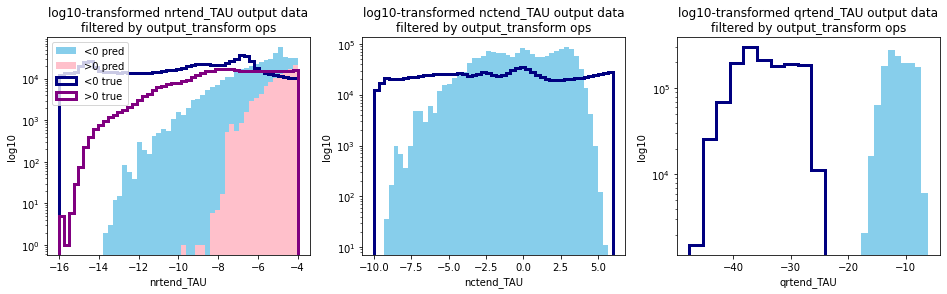

In [ ]:
# output visualizations

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
all_bins = [np.linspace(-16, -4, 50), np.linspace(-10, 6, 50), np.linspace(-200, 300, 50)]

output_col = "nrtend_TAU"
colp = unscaled_tendencies[output_col]
col = pred_tendencies[output_col]
ax1.hist(np.log10(-colp[colp < 0]), label="<0 pred", bins=all_bins[0], color='skyblue')
ax1.hist(np.log10(colp[colp > 0]), label=">0 pred", bins=all_bins[0], color='pink')
ax1.hist(np.log10(-col[col < 0]), label="<0 true", bins=all_bins[0], histtype="step", color="navy", lw=3)
ax1.hist(np.log10(col[col > 0]), label=">0 true", bins=all_bins[0], histtype="step", color="purple", lw=3)
ax1.set_xlabel(output_col)
ax1.set_ylabel('log10')
ax1.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax1.set_yscale('log')
ax1.legend()

output_col = "nctend_TAU"
colp = unscaled_tendencies[output_col]
col = pred_tendencies[output_col]
ax2.hist(np.log10(-colp[colp < 0]), label="pred", bins=all_bins[1], color='skyblue')
ax2.hist(np.log10(-col[col < 0]), label="true", bins=all_bins[1], histtype="step", color="navy", lw=3)
ax2.set_xlabel(output_col)
ax2.set_ylabel('log10')
ax2.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax2.set_yscale('log')

output_col = "qrtend_TAU"
colp = unscaled_tendencies[output_col]
col = pred_tendencies[output_col]
ax3.hist(np.log10(colp[colp > 0]), label="pred", color='skyblue')
ax3.hist(np.log10(col[col > 0]), label="true", histtype="step", color="navy", lw=3)
ax3.set_xlabel(output_col)
ax3.set_ylabel('log10')
ax3.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
ax3.set_yscale('log')

plt.show()

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
# Wednesday's code goes here

### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [ ]:
# Thursday's code goes here

## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.